## UWCNN++

UWCNN++ builds upon the original UWCNN model, introducing refinements for enhanced underwater image and video restoration. Inspired by underwater scene priors and deep learning advancements, this approach aims to improve colour correction, contrast enhancement, and visibility restoration in challenging aquatic environments.

For detailed insights, refer to the original source: [Final Report](https://github.com/MACILLAS/UWCNN/blob/wtf/final_report.pdf)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
if not os.path.isdir("UWCNN"):
    !git clone https://github.com/MACILLAS/UWCNN.git
else:
    print("[ INFO ] UWCNN repository was already downloaded.")

[ INFO ] UWCNN repository was already downloaded.


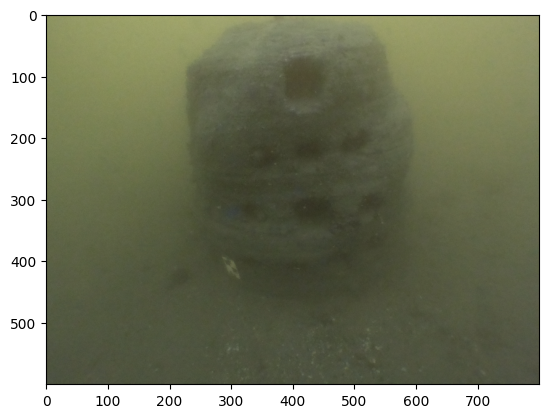

In [3]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("Dataset/G0041984.JPG")
img = cv2.resize(img, (800, 600))
plt.imshow(img)

## UWCNN++ Model

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.layers import Conv2D, BatchNormalization, SpatialDropout2D, ReLU, Input, Concatenate, Add

E0000 00:00:1742466605.399261  218181 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742466605.404321  218181 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742466605.417852  218181 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742466605.417877  218181 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742466605.417879  218181 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742466605.417880  218181 computation_placer.cc:177] computation placer already registered. Please check linka

In [5]:
def combloss (y_actual, y_predicted):
    '''
    This is the custom loss function for keras model
    :param y_actual:
    :param y_predicted:
    :return:
    '''
    # this is just l2 + lssim
    lssim = tf.constant(1, dtype=tf.float32) - tf.reduce_mean(tf.image.ssim(y_actual, y_predicted, max_val=1, filter_size=13)) #remove max_val=1.0
    lmse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)(y_actual, y_predicted)
    lmse = tf.math.multiply(lmse, 4)
    return tf.math.add(lmse, lssim)

class UWCNN(tf.keras.Model):

    def __init__(self,name=None):
        super(UWCNN, self).__init__()
        self.conv1 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze1")
        self.relu1 = ReLU()
        self.conv2 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze2")
        self.relu2 = ReLU()
        self.conv3 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze3")
        self.relu3 = ReLU()
        self.concat1 = Concatenate(axis=3)

        self.conv4 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze4")
        self.relu4 = ReLU()
        self.conv5 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze5")
        self.relu5 = ReLU()
        self.conv6 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze6")
        self.relu6 = ReLU()
        self.concat2 = Concatenate(axis=3)

        self.conv7 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze7")
        self.relu7 = ReLU()
        self.conv8 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze8")
        self.relu8 = ReLU()
        self.conv9 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze9")
        self.relu9 = ReLU()
        self.concat3 = Concatenate(axis=3)

        self.conv10 = Conv2D(3, 3, (1, 1), 'same', name="conv2d_dehaze10")
        self.add1 = Add()

    def call(self, inputs):
        image_conv1 = self.relu1(self.conv1(inputs))
        image_conv2 = self.relu2(self.conv2(image_conv1))
        image_conv3 = self.relu3(self.conv3(image_conv2))
        dehaze_concat1 = self.concat1([image_conv1, image_conv2, image_conv3, inputs])

        image_conv4 = self.relu4(self.conv4(dehaze_concat1))
        image_conv5 = self.relu5(self.conv5(image_conv4))
        image_conv6 = self.relu6(self.conv6(image_conv5))
        dehaze_concat2 = self.concat2([dehaze_concat1, image_conv4, image_conv5, image_conv6])

        image_conv7 = self.relu7(self.conv7(dehaze_concat2))
        image_conv8 = self.relu8(self.conv8(image_conv7))
        image_conv9 = self.relu9(self.conv9(image_conv8))
        dehaze_concat3 = self.concat3([dehaze_concat2, image_conv7, image_conv8, image_conv9])

        image_conv10 = self.conv10(dehaze_concat3)
        out = self.add1([inputs, image_conv10])
        return out

def get_model():
    return UWCNN(name="UWCNN")

def parse_function(filename, label):
    filename_image_string = tf.io.read_file(filename)
    label_image_string = tf.io.read_file(label)
    # Decode the filename_image_string
    filename_image = tf.image.decode_bmp(filename_image_string, channels=3)
    filename_image = tf.image.convert_image_dtype(filename_image, tf.float32)
    # Decode the label_image_string
    label_image = tf.image.decode_bmp(label_image_string, channels=3)
    label_image = tf.image.convert_image_dtype(label_image, tf.float32)
    return filename_image, label_image

def combloss (y_actual, y_predicted):
    '''
    This is the custom loss function for keras model
    :param y_actual:
    :param y_predicted:
    :return:
    '''
    # this is just l2 + lssim
    lssim = tf.constant(1, dtype=tf.float32) - tf.reduce_mean(tf.image.ssim(y_actual, y_predicted, max_val=1, filter_size=13)) #remove max_val=1.0
    lmse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)(y_actual, y_predicted)
    lmse = tf.math.multiply(lmse, 4)
    return tf.math.add(lmse, lssim)

In [6]:
model = UWCNN()
input_shape=(16,) + img.shape
model.build(input_shape)
model.summary()
model.load_weights('UWCNN/UWCNN++/train_type1/model.h5')

/opt/miniconda3/envs/underwater/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'uwcnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "uwcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_dehaze1 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze2 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze3 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze4 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze5 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze6 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze7 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze8 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze9 (Conv2D)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_2 (Concatenate)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_dehaze10 (Conv2D)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
import glob
imgs = sorted(glob.glob("Dataset/*"))

In [12]:
if not os.path.isdir("Output_UWCNN"):
    os.makedirs("Output_UWCNN")

for img in imgs:
  filename_image_string = tf.io.read_file(img)
  filename_image = tf.image.decode_png(filename_image_string, channels=3)
  filename_image = tf.image.convert_image_dtype(filename_image, tf.float32)
  filename_image = tf.image.resize(filename_image, (460, 620))
  # filename_image = tf.image.resize(filename_image, (600, 800))
  filename_image = tf.reshape(filename_image, [1, 460, 620, 3])
  output = model.predict(filename_image)
  output = output.reshape((460, 620, 3)) * 255
  # output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
  cv2.imwrite("Output_UWCNN/"+"out_"+ os.path.basename(img), output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


## Results Visualization

In [13]:
imgs_out = sorted(glob.glob("Output_UWCNN/*"))

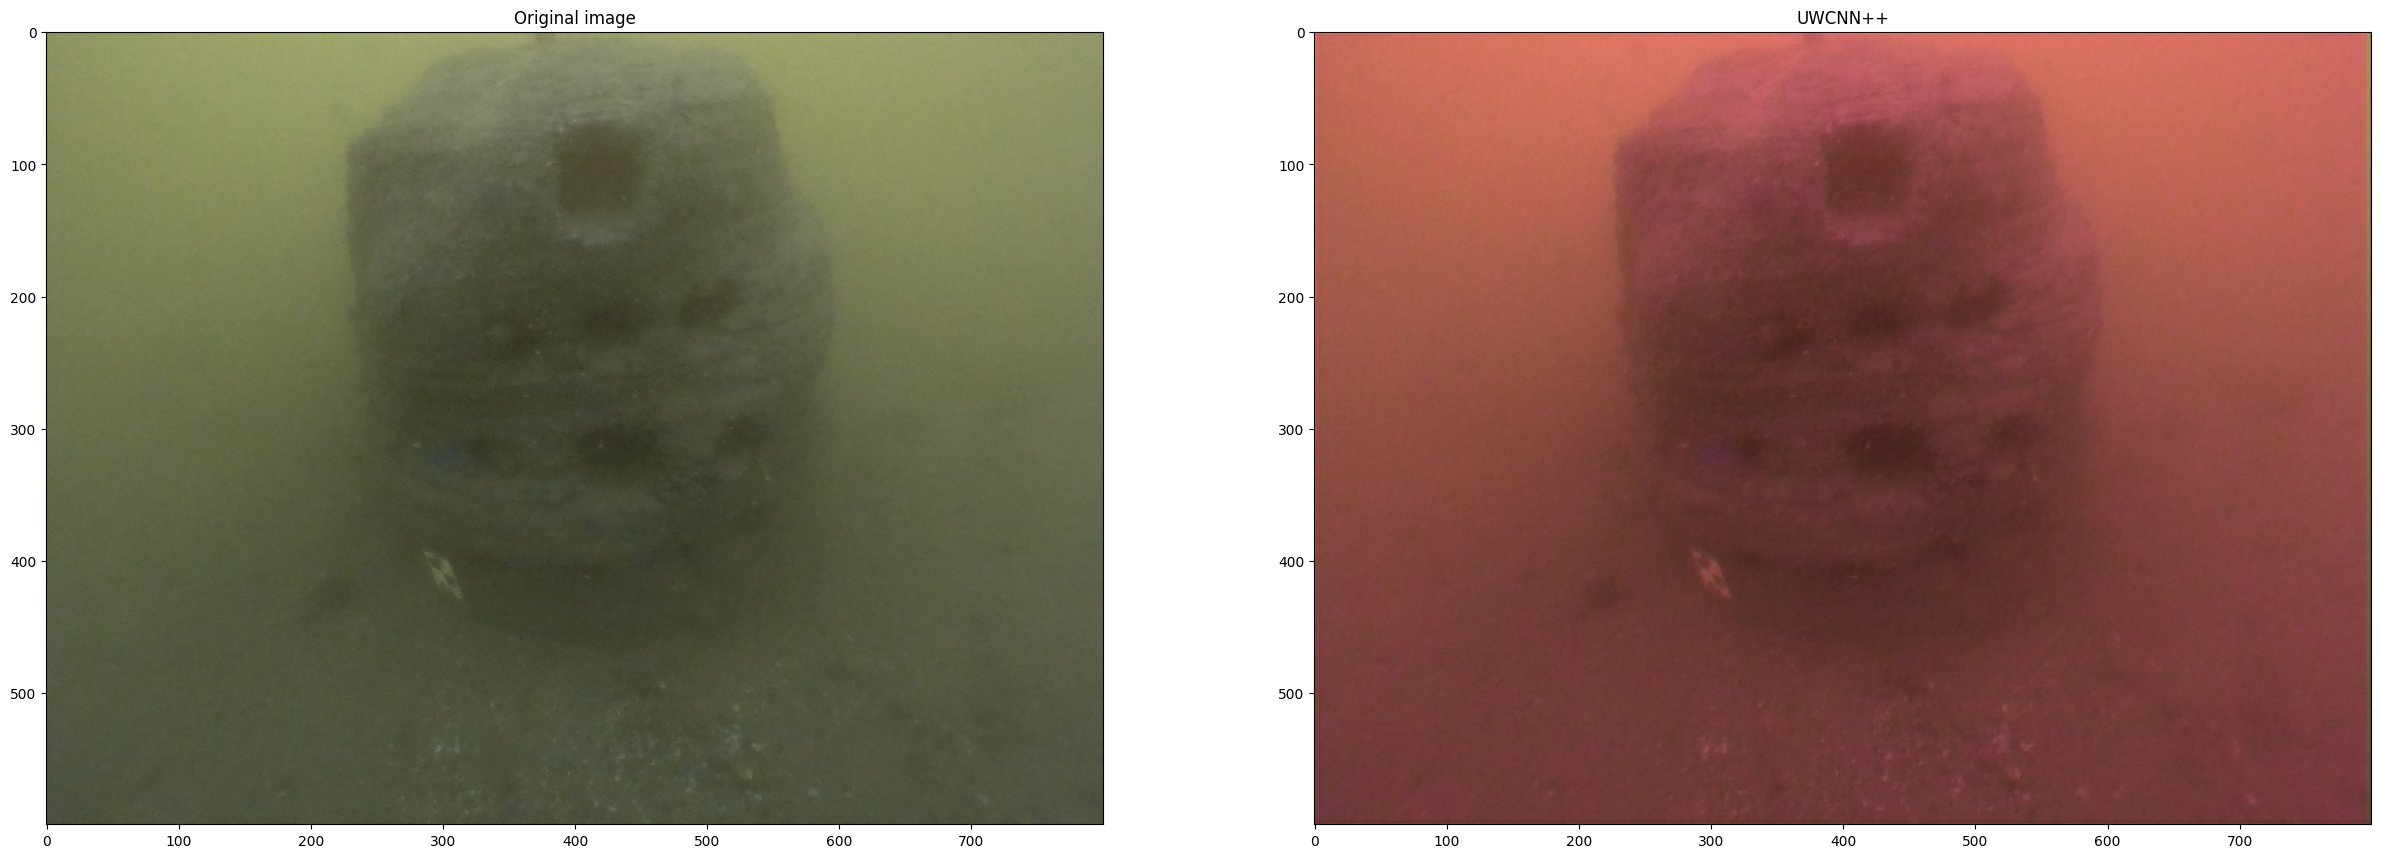

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 30))
im = cv2.imread(imgs[0])
im = cv2.resize(im, (800, 600))

ax[0].imshow(im)
ax[0].set_title("Original image")

out_img = cv2.imread(imgs_out[0])
out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
out_img = cv2.resize(out_img, (800, 600))

ax[1].imshow(out_img)
ax[1].set_title("UWCNN++")

plt.show()

## Evalution metrics

Please refer to the [original source](https://github.com/Riccellisp/ProjetoPecem/blob/ba8c5e7b991e93044e3c86c42e48d3df4c9595fb/metrics.py) of the metric.

In [17]:
import sys
import math
import numpy as np
from skimage import color,filters
from skimage.metrics import structural_similarity as ssim

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)

    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]

            block = ch[xlb:xrb,ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)
            m = bottom and top / bottom or 0
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

def eme(img,rowSample,columnSample):
	grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	rowSize, columnSize = grayImg.shape
	nRows = int(rowSize/rowSample)
	nColumns = int(columnSize/columnSample)
	incompleteRow = math.ceil(rowSize/rowSample) - nRows
	incompleteColumn = math.ceil(columnSize/columnSample) - nColumns

	somatory = 0
	nBlocks = nRows*nColumns
	for i in range(0,nRows):
		for j in range(0,nColumns):
			imax=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)

	if incompleteColumn==1:
		for i in range(0,nRows):
			imax=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1:
		for j in range(0,nColumns):
			imax=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].max()
			imin=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1 and incompleteColumn==1:
		imax=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		imin=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		if imin==0:
			imin=1
		if imax==0:
			imax=1
		somatory = somatory + 20*math.log(imax/imin)
		nBlocks = nBlocks + 1
	return somatory/nBlocks

def UCIQE(a,c1=0.4680,c2 = 0.2745,c3 = 0.2576):
    """
    M. Yang and A. Sowmya, "An Underwater Color Image Quality Evaluation Metric" in IEEE Transactions on Image Processing,
    vol. 24, no. 12, pp. 6062-6071, Dec. 2015, doi: 10.1109/TIP.2015.2491020.
    
    The Underwater Colour Image Quality Evaluation Metric (UCIQE) is a metric based on the linear combination of chroma (purity),
    saturation, and contrast, primarily for underwater images but also influenced by recent studies on the evaluation of atmospheric
    colour images.
    """
    rgb = a
    lab = color.rgb2lab(a)
    l = lab[:,:,0]

    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    top = int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top])-np.mean(sl[:top])

    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
      if chroma1[i] == 0: satur.append(0)
      elif l1[i] == 0: satur.append(0)
      else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    return  c1 * sc + c2 * conl + c3 * us

def UIQM(a,p1=0.0282,p2=0.2953,p3=3.5753):
    """
    K. Panetta, C. Gao and S. Agaian, Human-Visual-System-Inspired Underwater Image Quality Measures,
    in IEEE Journal of Oceanic Engineering, vol. 41, no. 3, pp. 541-551, July 2016, doi: 10.1109/JOE.2015.2469915.
    
    Similar to UCIQE, but more up-to-date. It takes into account the measure of colouration, sharpness, and contrast.
    """

    rgb = a
    gray = color.rgb2gray(a)
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr) # μ^2_α,RG
    s2rg = np.mean((rgl_tr - urg) ** 2)  # σ2α,RG
    uyb = np.mean(ybl_tr) # μ^2_α,YB
    s2yb = np.mean((ybl_tr- uyb) ** 2) # σ2α,YB

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    Reme = eme(a,8,8)
    Geme = eme(a,8,8)
    Beme = eme(a,8,8)
    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    uiconm = logamee(gray)
    uiqm = p1 * uicm + p2 * uism + p3 * uiconm

    return uiqm

def CCF(imageRGB):
	"""
    @article{WANG2018904,
    	title = {An imaging-inspired no-reference underwater color image quality assessment metric},
    	journal = {Computers & Electrical Engineering},
    	volume = {70},
    	pages = {904-913},
    	year = {2018},
    	issn = {0045-7906},
    	doi = {https://doi.org/10.1016/j.compeleceng.2017.12.006},
    	url = {https://www.sciencedirect.com/science/article/pii/S0045790617324953},
    	author = {Yan Wang and Na Li and Zongying Li and Zhaorui Gu and Haiyong Zheng and Bing Zheng and Mengnan Sun},
    	keywords = {No-reference image quality assessment, Underwater imaging, Underwater image, Underwater color image quality},
    	abstract = {Underwater color image quality assessment (IQA) plays an important role in analysis and applications of underwater imaging as well as image processing algorithms. This paper presents a new metric inspired by the imaging analysis on underwater absorption and scattering characteristics, dubbed the CCF. This metric is feature-weighted with a combination of colorfulness index, contrast index and fog density index, which can quantify the color loss caused by absorption, the blurring caused by forward scattering and the foggy caused by backward scattering, respectively. Then multiple linear regression is used to calculate three weighted coefficients. A new underwater image database is built to illustrate the performance of the proposed metric. Experimental results show a strong correlation between the proposed metric and mean opinion score (MOS). The proposed CCF metric outperforms many of the leading atmospheric IQA metrics, and it can effectively assess the performance of underwater image enhancement and image restoration methods.}
    }

	This metric is weighted by features using a combination of a colourfulness index, a contrast index, and a fog density index,
    which can quantify colour loss caused by absorption, blurring caused by forward scattering, and fogging caused by backward 
    scattering, respectively.
	"""
	rgb=imageRGB
	gray = color.rgb2gray(imageRGB)
    
	# Passo 1
	Rij=np.log(rgb[:,:,0])-np.mean(rgb[:,:,0])
	Gij=np.log(rgb[:,:,1])-np.mean(rgb[:,:,1])
	Bij=np.log(rgb[:,:,2])-np.mean(rgb[:,:,2])

	# Passo 2
	a = rgb[:,:,0] - rgb[:,:,1]
	b = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]

	var_a  = np.var(a)
	var_b  = np.var(b)
	mean_a = np.mean(a)
	mean_b = np.mean(b)

	ccf=(math.sqrt(var_a+var_b)+0.3*math.sqrt(var_a+var_b)) /85.59

	return ccf

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
%%time
UIQM_list, UCIQE_list, CCF_list  = list(), list(), list()
UIQM_out_list, UCIQE_out_list, CCF_out_list  = list(), list(), list()

for img in imgs:
    im = cv2.imread(img)
    im = cv2.resize(im, (800, 600))
    UIQM_list.append(UIQM(im))
    UCIQE_list.append(UCIQE(im))
    CCF_list.append(CCF(im))

for img in imgs_out:
    im = cv2.imread(img)
    im = cv2.resize(im, (800, 600))
    UIQM_out_list.append(UIQM(im))
    UCIQE_out_list.append(UCIQE(im))
    CCF_out_list.append(CCF(im))

CPU times: user 17.1 s, sys: 2.13 s, total: 19.2 s
Wall time: 17.8 s


In [19]:
from tabulate import tabulate
data = [
    ["UIQM", np.mean(UIQM_list), np.std(UIQM_list)],
    ["UCIQE", np.mean(UCIQE_list), np.std(UCIQE_list)],
    ["CCF", np.mean(CCF_list), np.std(CCF_list)],
    ["UIQM_UWCNN", np.mean(UIQM_out_list), np.std(UIQM_out_list)],
    ["UCIQE_UWCNN", np.mean(UCIQE_out_list), np.std(UCIQE_out_list)],
    ["CCF_UWCNN", np.mean(CCF_out_list), np.std(CCF_out_list)],
]

headers = ["Metric", "Mean", "Standard Deviation"]
print(tabulate(data, headers=headers, tablefmt="simple_grid", numalign="right"))

┌─────────────┬──────────┬──────────────────────┐
│ Metric      │     Mean │   Standard Deviation │
├─────────────┼──────────┼──────────────────────┤
│ UIQM        │ 0.400654 │             0.156042 │
├─────────────┼──────────┼──────────────────────┤
│ UCIQE       │  16.9709 │              2.73291 │
├─────────────┼──────────┼──────────────────────┤
│ CCF         │ 0.755423 │              0.30076 │
├─────────────┼──────────┼──────────────────────┤
│ UIQM_UWCNN  │ 0.333603 │             0.256514 │
├─────────────┼──────────┼──────────────────────┤
│ UCIQE_UWCNN │  17.9915 │               3.1553 │
├─────────────┼──────────┼──────────────────────┤
│ CCF_UWCNN   │  1.11536 │              0.35521 │
└─────────────┴──────────┴──────────────────────┘
